# CarRacing-v0

In [25]:
import numpy as np
import os
import json
import tensorflow as tf
import random
from vae.vae import CVAE
from controller import make_controller
from env import make_env
from utils import PARSER
args = PARSER.parse_args(['--config_path', 'configs/carracing.config'])

In [26]:
import matplotlib.pyplot as plt
import matplotlib.animation
%matplotlib inline
np.set_printoptions(precision=4, edgeitems=6, linewidth=100, suppress=True)

In [27]:
os.environ["CUDA_VISIBLE_DEVICES"]="-1" # disable GPU

DATA_DIR = "results/{}/{}/record".format(args.exp_name, args.env_name)
model_path_name = "results/{}/{}/tf_vae".format(args.exp_name, args.env_name)

In [28]:
filelist = os.listdir(DATA_DIR)

In [29]:
obs = np.load(os.path.join(DATA_DIR, random.choice(filelist)))["obs"]
obs = obs.astype(np.float32)/255.0

In [30]:
obs.shape

(1000, 64, 64, 3)

In [31]:
frame = random.choice(obs).reshape(1, 64, 64, 3)

# Simulate and Store for Animation

In [32]:
def sim(c, env, vae, is_true_env=False, z_size=64, max_ep_len=1000):
    o = env.reset()
    r_list = []
    total_r_list = []
    true_frames = []
    if is_true_env:
        o, frame = o
        true_frames.append(tf.squeeze(frame))
        z = np.expand_dims(o[:z_size], axis=0)
        reconstruct = vae.decode(z)
    else:
        z = np.expand_dims(o[:z_size], axis=0)
        reconstruct = vae.decode(z)
    decoded_frames = [tf.squeeze(reconstruct)]
    
    for _ in range(max_ep_len): # episode length is a thousand
        a = c.get_action(o)
        o, r, d, _ = env.step(a)
        r_list.append(r)
        total_r_list.append(sum(r_list))
        if is_true_env:
            env.render('rgb_array')
            o, frame = o
            true_frames.append(tf.squeeze(frame))
            z = np.expand_dims(o[:z_size], axis=0)
            reconstruct = vae.decode(z)
        else:
            z = np.expand_dims(o[:z_size], axis=0)
            reconstruct = vae.decode(z)
        decoded_frames.append(tf.squeeze(reconstruct))
        
        if d:
            break
    return decoded_frames, true_frames, r_list, total_r_list

In [33]:
vae = CVAE(args)

vae.set_weights(tf.keras.models.load_model(model_path_name, compile=False).get_weights())


Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6a05c96f98> and <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6a05c43400>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6a05c43400> and <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6a05c43198>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6a05c43198> and <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6a05cb16d8>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f6a05cb16d8> and <tensorflow.python.keras.layers.core.Flatten object at 0x7f6a05cb9438>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x7f6a05c

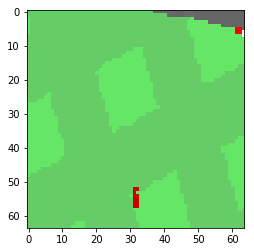

In [34]:
%matplotlib inline
# show recorded frame that will be fed into the input of VAE
plt.imshow(frame[0])
plt.show()

In [35]:
batch_z = vae.encode(frame)
print(batch_z[0]) # print out sampled z
reconstruct = vae.decode(batch_z)

tf.Tensor(
[-0.7689  1.0077  0.8579  0.181   1.1044  0.2689  0.7899 -0.0133 -0.7203  1.1184 -0.3693  0.4563
 -1.4311  2.1303  0.1423  0.7457  0.7023  0.2201  0.6683 -1.5326  0.1265 -0.3237  0.3994 -0.5313
 -0.0547 -0.3562 -1.3314  0.1546 -1.2871  0.0344  0.5641 -0.7688], shape=(32,), dtype=float32)


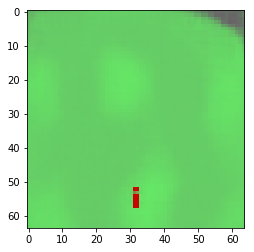

In [36]:
%matplotlib inline
# show reconstruction
plt.imshow(reconstruct[0])
plt.show()

## Dream Samples

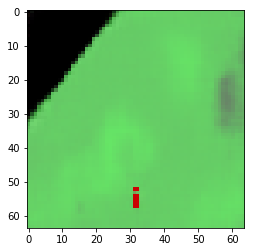

In [37]:
%matplotlib inline
batch_z = tf.random.normal((1, args.z_size)).numpy()
reconstruct = vae.decode(batch_z)
# show reconstruction
plt.imshow(reconstruct[0])
plt.show()

## Return Plot for Controller

In [38]:
eager_filepath = os.path.join('results/{}/{}/log/{}.cma.16.4.eval_hist.json'.format(args.exp_name, args.env_name, args.env_name))
og_filepath = os.path.join('results/og/log', 'carracing.cma.16.64.hist_best.json')
with open(eager_filepath, 'r') as f:
  eager_data = json.load(f)
with open(og_filepath, 'r') as f:
  og_data = json.load(f)

eager_data = np.array(eager_data)
og_data = np.array(og_data)

eager_comparison_max = eager_data[-1, 0] # b/c we didnt run for 2k
og_max_idx = np.sum(np.array(og_data[: ,0],dtype=np.float) <= eager_comparison_max)
print(og_max_idx)

og_data = np.array(og_data)[:og_max_idx]

4


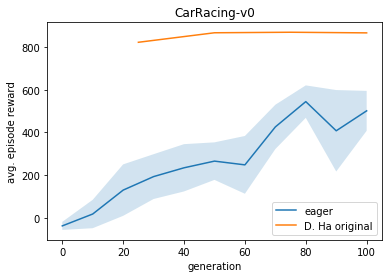

In [39]:
%matplotlib inline

eager_x = eager_data[:, 0]
eager_ret = eager_data[:, 1]
eager_std = eager_data[:, 2]

og_x = np.array(og_data[:, 0], dtype=np.float)
og_ret = np.array(og_data[:, 5], dtype=np.float)
# don't have access to standard deviation of the og evaluation

plt.figure()
plt.plot(eager_x, eager_ret)
plt.fill_between(eager_x, eager_ret-eager_std, eager_ret+eager_std, alpha=0.2)
plt.plot(og_x, og_ret)

plt.title('CarRacing-v0')
plt.ylabel('avg. episode reward')
plt.xlabel('generation')
plt.legend(['eager', 'D. Ha original']);

In [40]:
eager_filepath = os.path.join('results/{}/{}/log/{}.cma.16.4.eval_hist.json'.format(args.exp_name, args.env_name, args.env_name))

with open(eager_filepath, 'r') as f:
  eager_data = json.load(f)
eager_data = np.array(eager_data)

eager_generation = int(eager_data[10, 0])
eager_ret = eager_data[10, 1]
eager_std = eager_data[10, 2]

og_generation = 2000
og_tau_1_ret = 868.0
og_tau_1_std = 511.0

print(eager_generation, eager_ret, eager_std)
print(og_generation, og_tau_1_ret, og_tau_1_std)

100 501.36725 93.57912624151284
2000 868.0 511.0


|  | generation | returns &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|
|------|------|---------|
|   OG WorldModels  | 2000 | $868 \pm 511$ |
|   Eager WorldModels  | 100 | $501 \pm 94$ |

In [41]:
import tensorflow as tf
import tensorflow.keras as keras

In [42]:
encdr = keras.models.load_model('./vae_gan/saved-models/E_training_0.h5')

In [43]:
gen = keras.models.load_model('./vae_gan/saved-models/G_training_0.h5')

In [44]:
gen.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512)]             0         
_________________________________________________________________
dense_3 (Dense)              (None, 16384)             8404992   
_________________________________________________________________
batch_normalization_4 (Batch (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 256)       1638656   
_________________________________________________________________
batch_normalization_5 (Batch (None, 16, 16, 256)       1024

In [45]:
latent = encdr(frame[0][None,:,:,:])

In [46]:
recon = gen(latent[0])

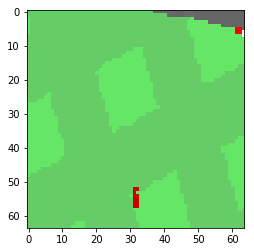

In [47]:
plt.imshow(frame[0]);

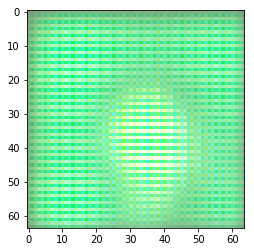

In [48]:
plt.imshow(recon[0]);